# Project Overview 
By leveraging the National Poll on Healthy Aging dataset, I can conduct data-driven analysis on various topics (e.g. health insurance coverage, dental care, caregiving) to gain valuable insights into the health-related needs and concerns of the older population.

**Goal**
- Predict the number of doctors a patient(aged 50 and older) will visit based on their physical, mental, and dental health status along with other lifestyle factors. 

**Impact**
- It may help identify patients who are more likely to be high utilizers of healthcare resources. This could enable more proactive outreach and care management to address underlying needs.
- Insurers or health systems may utilize predictions to better allocate resources and plan staffing needs.
- Clinically, insights gained might assist providers in assessing patients’ future care needs in a more data-driven manner.


**Expected Outcome**

-


**Data**
- Origin: A subset of the National Poll on Healthy Aging (NPHA) dataset from UCI
- Link: https://archive.ics.uci.edu/dataset/936/national+poll+on+healthy+aging+(npha)
- Dataset Characteristics: Tabular
- Subject Area: Health and Medicine
- Associated Tasks: Classification
- Feature Type: Categorical
- Instances: 714
- Features: 14
- Additional Variable Information:
  Class Label for Number of Doctors Visited: The total count of different doctors the patient has seen = {
     1: 0-1 doctors, 2: 2-3 doctors, 3: 4 or more doctors }

**Data Problem**
- A lack of diversity in the age group: All the entries fall into the "65-80" age category.
- Imbalanced dataset in the racial or ethnic background: A significant overrepresentation of the "White, Non-Hispanic" category compared to other categories.

# Import Libraries

In [2355]:
from ucimlrepo import fetch_ucirepo 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, recall_score, classification_report, roc_auc_score, confusion_matrix, mean_squared_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.neighbors import KNeighborsClassifier
from timeit import default_timer as timer
import time
import warnings
warnings.filterwarnings("ignore")

# Fetch dataset 

In [2356]:
national_poll_on_healthy_aging_npha = fetch_ucirepo(id=936) 
  
# data (as pandas dataframes) 
X = national_poll_on_healthy_aging_npha.data.features 
y = national_poll_on_healthy_aging_npha.data.targets

In [2357]:
# Gather X and Y for visualizations
df = pd.concat([X,y], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 714 entries, 0 to 713
Data columns (total 15 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   Age                                         714 non-null    int64
 1   Physical_Health                             714 non-null    int64
 2   Mental_Health                               714 non-null    int64
 3   Dental_Health                               714 non-null    int64
 4   Employment                                  714 non-null    int64
 5   Stress_Keeps_Patient_from_Sleeping          714 non-null    int64
 6   Medication_Keeps_Patient_from_Sleeping      714 non-null    int64
 7   Pain_Keeps_Patient_from_Sleeping            714 non-null    int64
 8   Bathroom_Needs_Keeps_Patient_from_Sleeping  714 non-null    int64
 9   Uknown_Keeps_Patient_from_Sleeping          714 non-null    int64
 10  Trouble_Sleeping                      

In [2358]:
df.describe()

,Age,Physical_Health,Mental_Health,Dental_Health,Employment,Stress_Keeps_Patient_from_Sleeping,Medication_Keeps_Patient_from_Sleeping,Pain_Keeps_Patient_from_Sleeping,Bathroom_Needs_Keeps_Patient_from_Sleeping,Uknown_Keeps_Patient_from_Sleeping,Trouble_Sleeping,Prescription_Sleep_Medication,Race,Gender,Number_of_Doctors_Visited
count,714.0,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.000000,714.00000,714.000000
mean,2.0,2.794118,1.988796,3.009804,2.806723,0.247899,0.056022,0.218487,0.504202,0.417367,2.407563,2.829132,1.425770,1.55042,2.112045
std,0.0,0.900939,0.939928,1.361117,0.586582,0.432096,0.230126,0.413510,0.500333,0.493470,0.670349,0.546767,1.003896,0.49780,0.683441
min,2.0,-1.000000,-1.000000,-1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000,1.000000,1.00000,1.000000
25%,2.0,2.000000,1.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,3.000000,1.000000,1.00000,2.000000
50%,2.0,3.000000,2.000000,3.000000,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,3.000000,3.000000,1.000000,2.00000,2.000000
75%,2.0,3.000000,3.000000,4.000000,3.000000,0.000000,0.000000,0.000000,1.000000,1.000000,3.000000,3.000000,1.000000,2.00000,3.000000
max,2.0,5.000000,5.000000,6.000000,4.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,3.000000,5.000000,2.00000,3.000000


In [2359]:
print(df.head(3))

   Age  Physical_Health  Mental_Health  Dental_Health  Employment  \
0    2                4              3              3           3   
1    2                4              2              3           3   
2    2                3              2              3           3   

   Stress_Keeps_Patient_from_Sleeping  Medication_Keeps_Patient_from_Sleeping  \
0                                   0                                       0   
1                                   1                                       0   
2                                   0                                       0   

   Pain_Keeps_Patient_from_Sleeping  \
0                                 0   
1                                 0   
2                                 0   

   Bathroom_Needs_Keeps_Patient_from_Sleeping  \
0                                           0   
1                                           1   
2                                           0   

   Uknown_Keeps_Patient_from_Sleeping  Troub

# Data Cleaning
Handling -1(Refused), -2(Not asked) values in the features.

In [2360]:
# Check missing values.
df.isnull().sum()

# Filter out the rows with values -1 or -2 in the features.
for _, col in enumerate(X.columns):
    count = df[col].isin([-1, -2]).sum()
    print(col, count)
    df = df[~df[col].isin([-1, -2])]

Age 0
Physical_Health 1
Mental_Health 10
Dental_Health 3
Employment 0
Stress_Keeps_Patient_from_Sleeping 0
Medication_Keeps_Patient_from_Sleeping 0
Pain_Keeps_Patient_from_Sleeping 0
Bathroom_Needs_Keeps_Patient_from_Sleeping 0
Uknown_Keeps_Patient_from_Sleeping 0
Trouble_Sleeping 2
Prescription_Sleep_Medication 2
Race 0
Gender 0


# Analyze Class Distribution
I find bias towards Class 2. It will need to rebalance the data using techniques like SMOTE, random oversampling for underrepresented classes, or undersampling for the overrepresented class.

In [2361]:
# Calculate the class distribution
class_distribution = df['Number_of_Doctors_Visited'].value_counts()
print(class_distribution)

Number_of_Doctors_Visited
2    363
3    207
1    126
Name: count, dtype: int64


# Exploratory Data Analysis (EDA)

**1. The distribution of age, race, gender**

- It shows that 100% of the entries fall into the "65-80" age category as per the patient's age group, this indicates a strong bias or imbalance in the dataset regarding age distribution.

- Based on the distribution percentages for the patient's racial or ethnic background, it appears that the dataset is imbalanced with a significant overrepresentation of the "White, Non-Hispanic" category compared to other categories. We will drop `Age`,`Race` from featrues to avoid biased outcomes.

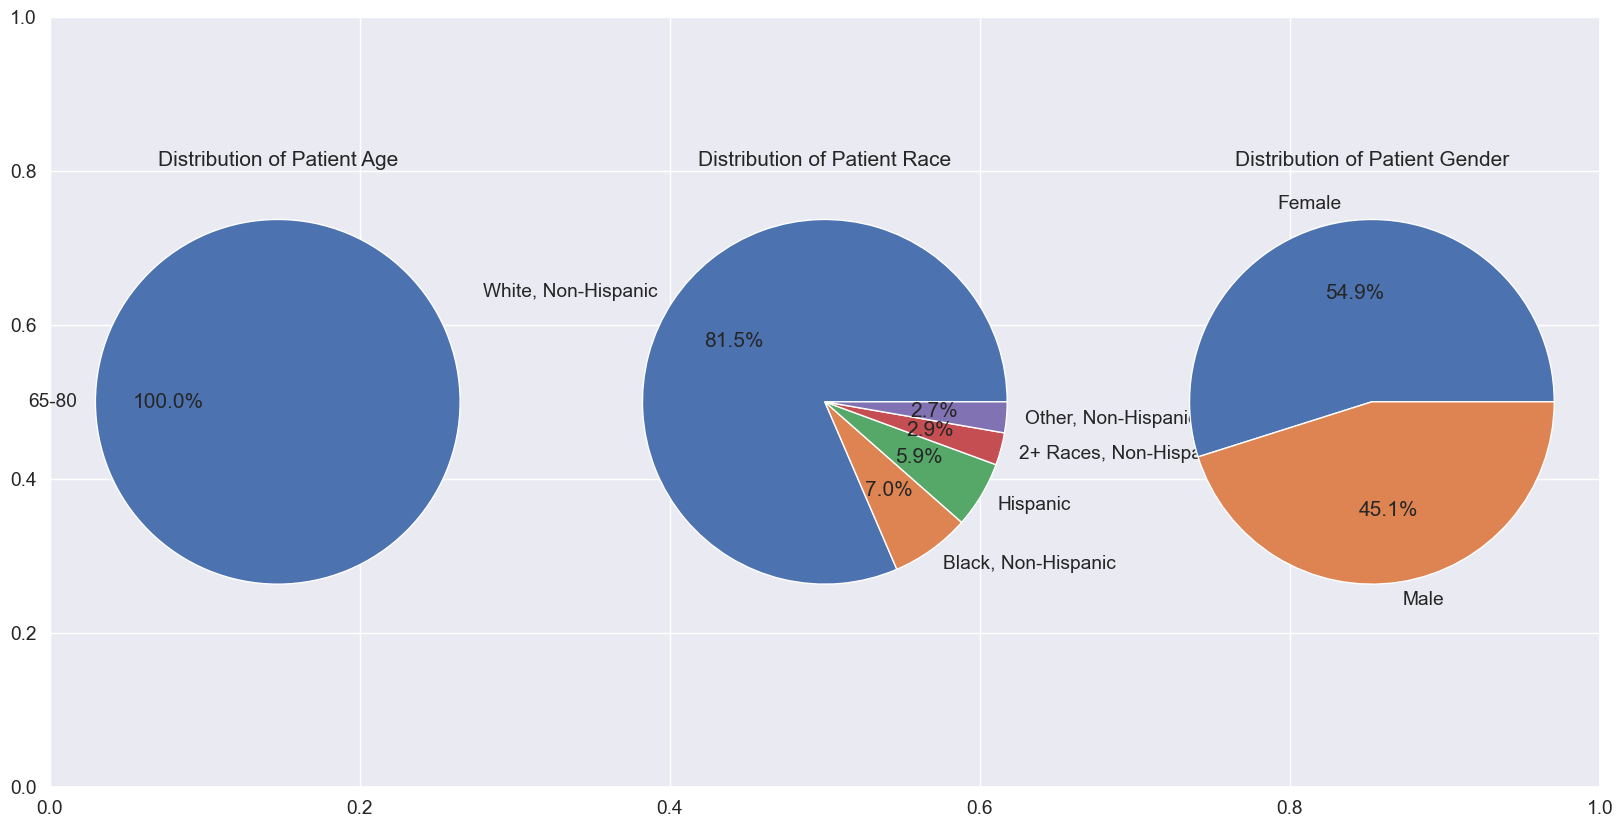

In [2362]:
df_ = df.copy()

age_dict = { 1: "50-64", 2: "65-80" }
df_['Age'] = df_['Age'].map(age_dict)

race_dict = { 1: "White, Non-Hispanic", 2: "Black, Non-Hispanic", 3: "Other, Non-Hispanic", 4: "Hispanic", 5: "2+ Races, Non-Hispanic" }
df_['Race'] = df_['Race'].map(race_dict)

gender_dict = { 1: "Male", 2: "Female" }
df_['Gender'] = df_['Gender'].map(gender_dict)

plt.subplots(figsize=(20, 10))
for i, col in enumerate(['Age', 'Race' , 'Gender']):
    plt.subplot(1, 3, i + 1)
 
    x = df_[col].value_counts()
    plt.title('Distribution of Patient ' + col)
    plt.pie(x.values,
            labels=x.index,
            autopct='%1.1f%%')
 
plt.show()

**2. The distribution of physical, mental, dental health and other lifestyle factors**

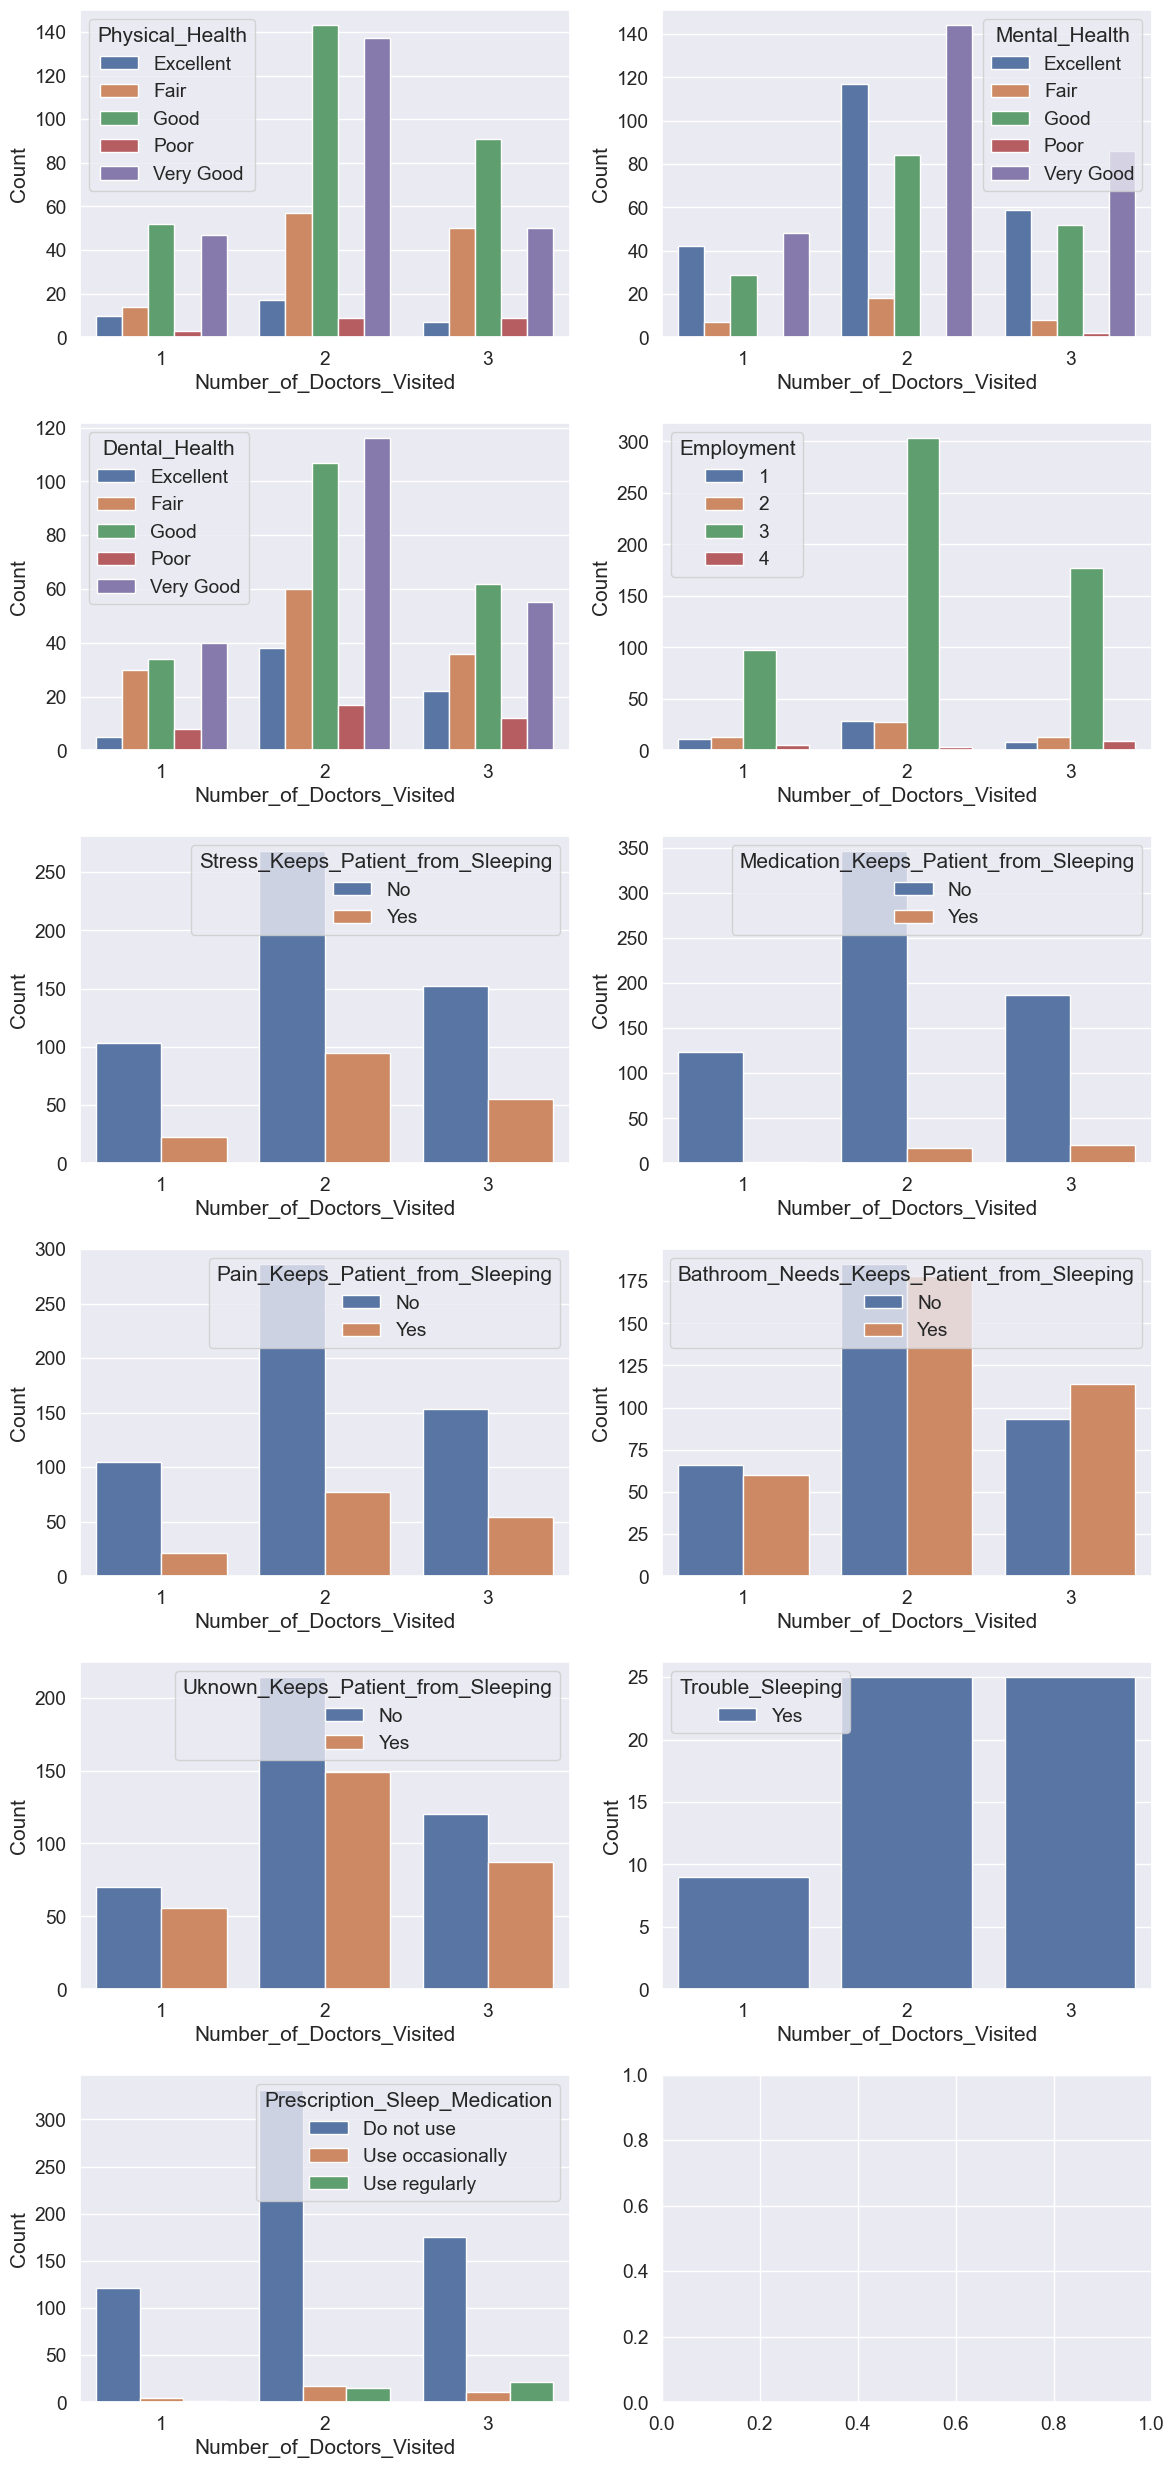

In [2363]:
health_dict = { 1: "Excellent", 2: "Very Good", 3: "Good",4: "Fair", 5: "Poor" }
sleep_dict= { 0: "No", 1: "Yes" }
prescription_dict = { 1: "Use regularly", 2: "Use occasionally", 3: "Do not use" }

df_['Physical_Health'] = df_['Physical_Health'].map(health_dict)
df_['Mental_Health'] = df_['Mental_Health'].map(health_dict)
df_['Dental_Health'] = df_['Dental_Health'].map(health_dict)
df_['Stress_Keeps_Patient_from_Sleeping'] = df_['Stress_Keeps_Patient_from_Sleeping'].map(sleep_dict)
df_['Medication_Keeps_Patient_from_Sleeping'] = df_['Medication_Keeps_Patient_from_Sleeping'].map(sleep_dict)
df_['Pain_Keeps_Patient_from_Sleeping'] = df_['Pain_Keeps_Patient_from_Sleeping'].map(sleep_dict)
df_['Bathroom_Needs_Keeps_Patient_from_Sleeping'] = df_['Bathroom_Needs_Keeps_Patient_from_Sleeping'].map(sleep_dict)
df_['Uknown_Keeps_Patient_from_Sleeping'] = df_['Uknown_Keeps_Patient_from_Sleeping'].map(sleep_dict)
df_['Trouble_Sleeping'] = df_['Trouble_Sleeping'].map(sleep_dict)
df_['Prescription_Sleep_Medication'] = df_['Prescription_Sleep_Medication'].map(prescription_dict)


cols = X.drop(columns=['Race', 'Age', 'Gender'])
fig, axes = plt.subplots(6, 2, figsize=(12, 25))

for i, col in enumerate(cols):
    row = i // 2
    column = i % 2
    count_data = df_.groupby([col, 'Number_of_Doctors_Visited']).size().reset_index(name='Count')
    
    # Plot the barplot for each state
    sns.barplot(x='Number_of_Doctors_Visited', y='Count', hue=col, data=count_data, ax=axes[row, column])
    # axes[row, column].set_title(col)

plt.tight_layout()
plt.show()

# Correlation Analysis
`Physical_Health` have strong correlation with `Number_of_Doctors_Visited` and strong interrelation with `Mental_Health`, indicating it is a significant predictor of healthcare utilization and overall health status.

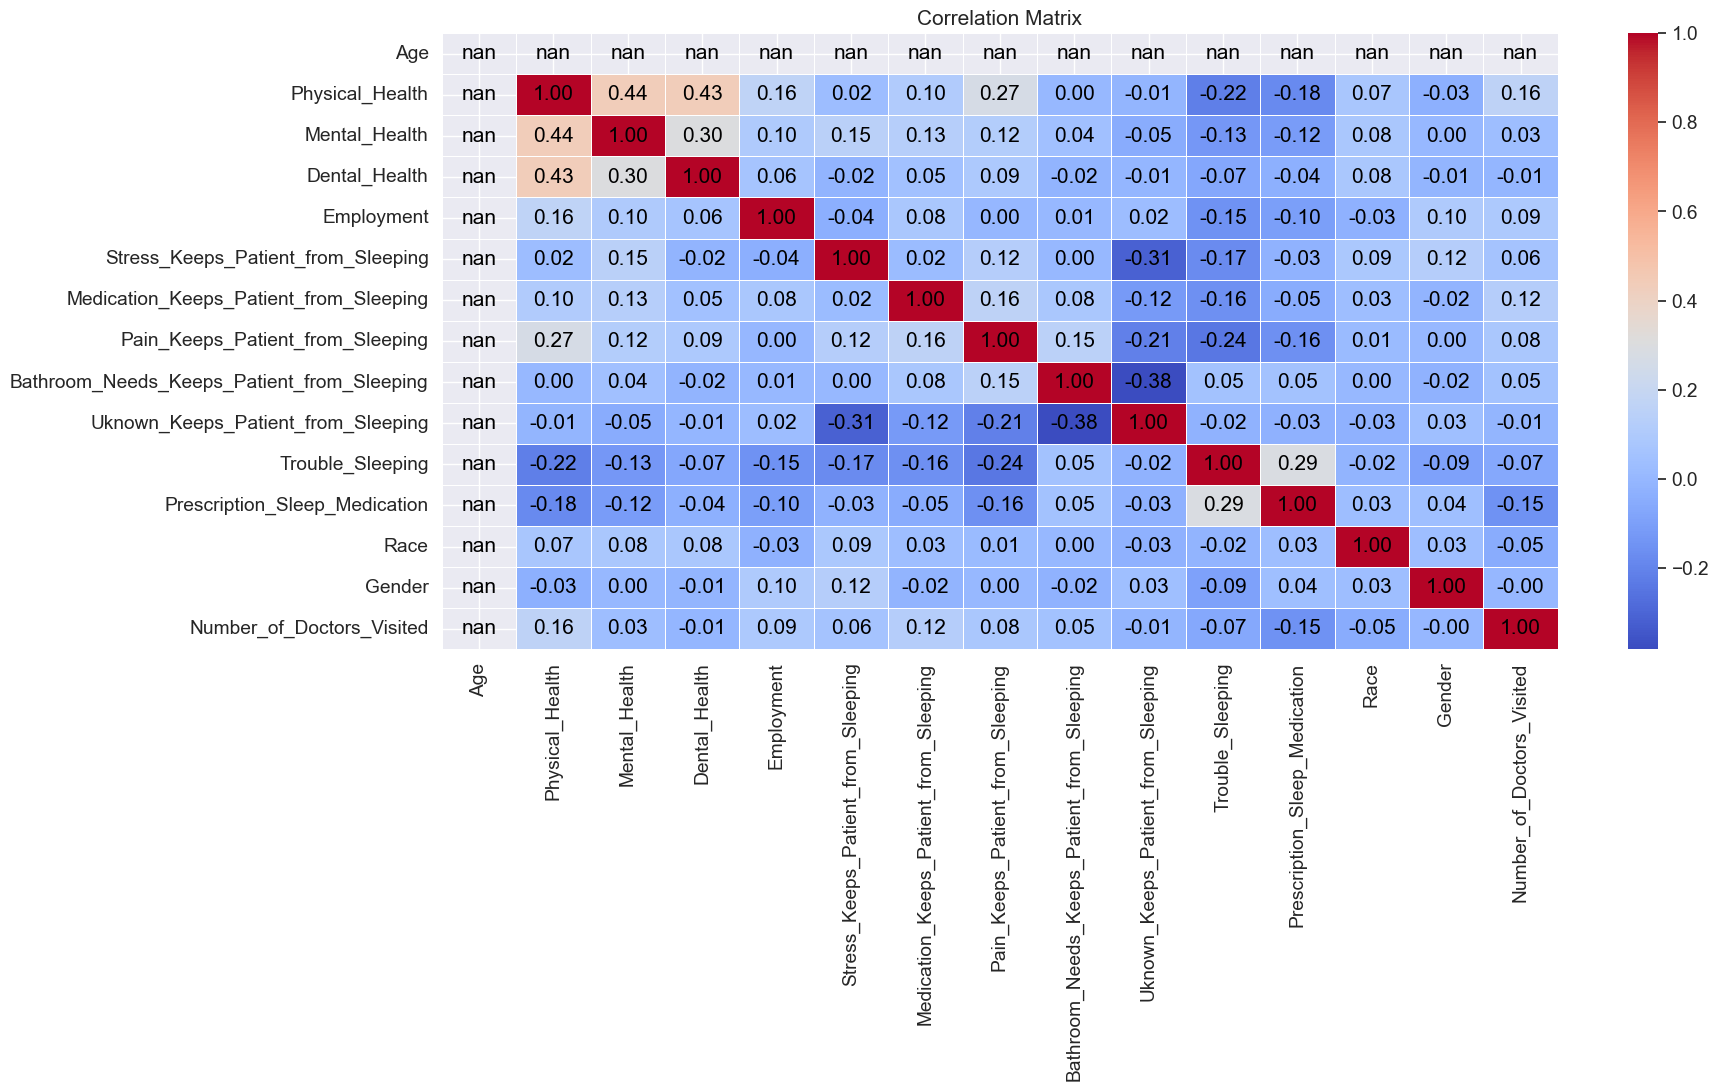

In [2364]:
# Calculate the correlation matrix
corr_matrix = df.corr()

# Create a heatmap
plt.figure(figsize=(18, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=0.5)

# Add annotations to the heatmap
for i in range(len(corr_matrix)):
    for j in range(len(corr_matrix)):
        text = f"{corr_matrix.iloc[i, j]:.2f}"
        plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')

plt.title("Correlation Matrix")
plt.show()

# Analysing Feature Importances

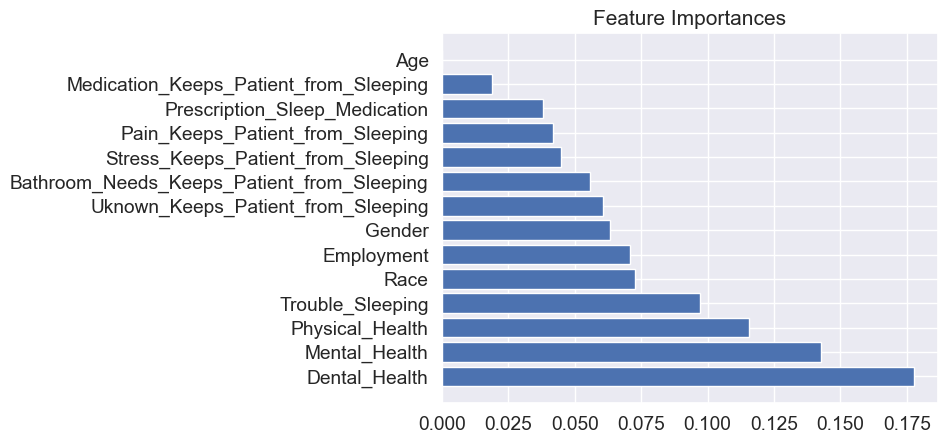

In [2365]:
model = RandomForestClassifier(n_estimators=300, random_state=42)
model.fit(X, y)

# Extract Feature Importances
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

# Plot the feature importances
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [X.columns[i] for i in indices])
plt.show()

# Feature Selection
In an effort to reduce dimensionality, one of approches I tried to combine various sleep-related disturbances into a single metric based on the Feature Importances and the Correlation Matrix but I didn't see a significant impact on model performance.
Domain experts could potentially provide insights into known clinical/causal links between certain variables.  

In [2366]:
columns_to_drop = ['Race', 'Age']
X = X.drop(columns=columns_to_drop)

# Model Development
**1. Spliting into Train and Test**

In [2367]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**2. SMOTE for Balancing Data**

The Synthetic Minority Oversampling Technique to generate synthetic samples for the minority class based on nearest neighbors.

I tested Random Forest, SVC models without resampling, the models were performing well on the majority class which is Class 2 but poorly on the minority class - Precision, recall, and F1-score were all 0 on Class 1. 
```
🚀 Random Forest
Average accuracy: 0.45385367762128326
Confusion Matrix:
 [[ 3 19  6]
 [ 1 53 20]
 [ 2 28 11]]
Classification Report:
               precision    recall  f1-score   support

           1       0.50      0.11      0.18        28
           2       0.53      0.72      0.61        74
           3       0.30      0.27      0.28        41

    accuracy                           0.47       143
   macro avg       0.44      0.36      0.36       143
weighted avg       0.46      0.47      0.43       143

🚀 SVC
Average accuracy: 0.5126564945226917
Confusion Matrix:
 [[ 0 27  1]
 [ 0 68  6]
 [ 0 34  7]]
Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00        28
           2       0.53      0.92      0.67        74
           3       0.50      0.17      0.25        41

    accuracy                           0.52       143
   macro avg       0.34      0.36      0.31       143
weighted avg       0.42      0.52      0.42       143
```
After oversampling using SMOTE, it shows improved Average Accuracy 0.58% on Random Forest and marginally improved the recall for Class 1 and Class 3.

In [2371]:
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
print("Class distribution after SMOTE:", Counter(y_train_resampled['Number_of_Doctors_Visited']))

Class distribution after SMOTE: Counter({3: 298, 2: 298, 1: 298})


**3. Feature Scaling**

In [2373]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

**4. Machine Learning Modeling**

Prediction and Evaluation: The model’s performance is evaluated using accuracy and a detailed classification report, which includes precision, recall, and F1-score for each class.
- Precision: Indicates the accuracy of positive predictions.
- Recall: Indicates the ability to find all positive instances.
- F1-Score: Harmonic mean of precision and recall.

In [2386]:
X_scaled = np.vstack((X_train_scaled, X_test_scaled))
y = np.concatenate((y_train_resampled, y_test))

# Initializing Models
models = {
    "LogisticRegression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "SVC": SVC(kernel ='linear'),
    "DecisionTree": DecisionTreeClassifier()
}

cv = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

# Producing cross validation score for the models
for model_name in models:
    model = models[model_name]
    
    # Evaluate the model's accuracy using cross-validation
    accuracies = cross_val_score(model, X_scaled, y, cv=cv, scoring='accuracy')
    
    print("🚀", model_name)
    print("Average accuracy:", np.mean(accuracies))

    model.fit(X_train_scaled, y_train_resampled)
    
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)

    # Print evaluation results
    print("Confusion Matrix:\n", cm)
    print("Classification Report:\n", class_report)

🚀 LogisticRegression
Average accuracy: 0.4203043315907394
Confusion Matrix:
 [[ 5 14  9]
 [22 26 26]
 [10 15 16]]
Classification Report:
               precision    recall  f1-score   support

           1       0.14      0.18      0.15        28
           2       0.47      0.35      0.40        74
           3       0.31      0.39      0.35        41

    accuracy                           0.33       143
   macro avg       0.31      0.31      0.30       143
weighted avg       0.36      0.33      0.34       143

🚀 Random Forest
Average accuracy: 0.5834111277072441
Confusion Matrix:
 [[ 6 13  9]
 [13 38 23]
 [ 5 22 14]]
Classification Report:
               precision    recall  f1-score   support

           1       0.25      0.21      0.23        28
           2       0.52      0.51      0.52        74
           3       0.30      0.34      0.32        41

    accuracy                           0.41       143
   macro avg       0.36      0.36      0.36       143
weighted avg       0.4

**5. Cross-validation Results** 

Based on the results above, the Random Forest model performs better compared to the other models.
- Average Accuracy: 58.34% (reported as higher, but confusion matrix suggests lower effective accuracy)
- Reported Accuracy: 41% as the effective accuracy, which reflects the proportion of total correct predictions across all classes.

# Bayesian Hyperparameter Optimization

**1. BayesSearchCV with RandomForestClassifier** 

BayesSearchCV from the scikit-optimize library is a powerful tool for hyperparameter tuning that uses Bayesian optimization techniques. 

In [2387]:
y_train = y_train_resampled['Number_of_Doctors_Visited'].values.ravel()

# Define the parameter search space
search_spaces = {
    'n_estimators': (10, 200),
    'max_depth': (1, 15),
    'min_samples_split': (2, 20),
    'min_samples_leaf': (1, 10)
}

# Create a BayesSearchCV instance
bayes_cv = BayesSearchCV(
    estimator=RandomForestClassifier(),
    search_spaces=search_spaces,
    n_iter=50,  
    cv=5,  
    n_jobs=-1,  
    scoring='accuracy'  
)

# Fit the optimizer to data
start_time = time.time()
bayes_cv.fit(X_train_scaled, y_train)
elapsed_time  = time.time() - start_time
print(elapsed_time)

# Evaluate the performance of the best estimator
print("train. score: %s" % bayes_cv.best_score_)
print("test score: %s" % bayes_cv.score(X_test_scaled, y_test))
print("best params: %s" % str(bayes_cv.best_params_))

best_estimator = bayes_cv.best_estimator_

64.17298889160156
train. score: 0.6488356035402674
test score: 0.38461538461538464
best params: OrderedDict([('max_depth', 13), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 200)])


**2. BayesSearchCV with SVC**

In [2391]:
# Define the parameter search space
search_space = {
    'C': Real(1e-6, 1e+6, prior='log-uniform'),
    'gamma': Real(1e-6, 1e+1, prior='log-uniform'),
    'kernel': Categorical(['linear', 'rbf']),
    # 'degree': Integer(1, 8)
}

# Create a BayesSearchCV instance
bayes_cv = BayesSearchCV(
    estimator=SVC(),
    search_spaces=search_space,
    scoring = 'accuracy',
    cv = 3,
    n_iter = 25,
    n_jobs = -1,
    random_state = 42 
)

# Fit the optimizer to data
start_time = time.time()
bayes_cv.fit(X_train_scaled, y_train)
elapsed_time  = time.time() - start_time
print(elapsed_time)

# Evaluate the performance of the best estimator
print("train. score: %s" % bayes_cv.best_score_)
print("test score: %s" % bayes_cv.score(X_test_scaled, y_test))
print("best params: %s" % str(bayes_cv.best_params_))

best_estimator = bayes_cv.best_estimator_

222.00801587104797
train. score: 0.5827740492170023
test score: 0.3776223776223776
best params: OrderedDict([('C', 1000000.0), ('gamma', 7.197736842221907), ('kernel', 'rbf')])


**3. BayesSearchCV with DecisionTreeClassifier**

In [2388]:
# Define the parameter search space
search_spaces = {
    'criterion': ['gini', 'entropy'],
    'max_depth': (1, 25),
    'min_samples_split': (2, 3),
    'min_samples_leaf': (1, 2),
}

# Create a BayesSearchCV instance
bayes_cv = BayesSearchCV(
    estimator=DecisionTreeClassifier(),
    search_spaces=search_spaces,
    n_iter=50,  
    cv=5, 
    n_jobs=-1,  
    scoring='accuracy'  
)

# Fit the optimizer to data
start_time = time.time()
bayes_cv.fit(X_train_scaled, y_train)
elapsed_time  = time.time() - start_time
print(elapsed_time)

# Evaluate the performance of the best estimator
print("train. score: %s" % bayes_cv.best_score_)
print("test score: %s" % bayes_cv.score(X_test_scaled, y_test))
print("best params: %s" % str(bayes_cv.best_params_))

best_estimator = bayes_cv.best_estimator_

58.003236055374146
train. score: 0.5928692486347373
test score: 0.3076923076923077
best params: OrderedDict([('criterion', 'gini'), ('max_depth', 25), ('min_samples_leaf', 1), ('min_samples_split', 2)])


## Model Evaluation

# References
1. How to Use SMOTE for an Imbalanced Dataset, <https://www.turing.com/kb/smote-for-an-imbalanced-dataset>